In [1]:
import matplotlib.pyplot as plt
from itertools import product
import numpy as np
from collections import Counter
from sklearn.base import BaseEstimator, RegressorMixin, ClassifierMixin
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_graphviz
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor, RandomForestClassifier
import graphviz
import sys

from IPython.display import Image

%matplotlib inline

# Load Data

In [2]:
data_train = np.loadtxt('svm-train.txt')
data_test = np.loadtxt('svm-test.txt')
x_train, y_train = data_train[:, 0: 2], data_train[:, 2].reshape(-1, 1)
x_test, y_test = data_test[:, 0: 2], data_test[:, 2].reshape(-1, 1)

In [3]:
# Change target to 0-1 label
y_train_label = np.array(list(map(lambda x: 1 if x > 0 else 0, y_train))).reshape(-1, 1)

# Decision Tree Class

### Q1: Complete the compute entropy and compute gini functions.

In [4]:
def compute_entropy(label_array):
    '''
    Calulate the entropy of given label list
    
    :param label_array: a numpy array of binary labels shape = (n, 1)
    :return entropy: entropy value
    '''
    # Your code goes here
    # sum of -1* p_mk * log2(p_mk), k = 1 ~ K , using log2 based on the discussion #329
    entropy = 0
    uniq_classes = np.unique(label_array)
        
    for each_class in uniq_classes:
        p = len(label_array[label_array == each_class]) / len(label_array)
        entropy += -1 * p * np.log2(p)
        
    return entropy
        
def compute_gini(label_array):
    '''
    Calulate the gini index of label list
    
    :param label_array: a numpy array of labels shape = (n, 1)
    :return gini: gini index value
    '''
    # Your code goes here
    # sum of p_mk * (1 - p_mk), k = 1 ~ K 
    gini = 0
    uniq_classes = np.unique(label_array)
        
    for each_class in uniq_classes:
        p = len(label_array[label_array == each_class]) / len(label_array)
        gini += p * (1-p)
        
    return gini

### Q2: Complete the class Decision Tree, given in the skeleton code.

In [26]:
class Decision_Tree(BaseEstimator):
     
    def __init__(self, split_loss_function, leaf_value_estimator,
                 depth=0, min_sample=5, max_depth=10):
        '''
        Initialize the decision tree classifier

        :param split_loss_function: method with args (X, y) returning loss
        :param leaf_value_estimator: method for estimating leaf value from array of ys
        :param depth: depth indicator, default value is 0, representing root node
        :param min_sample: an internal node can be splitted only if it contains points more than min_smaple
        :param max_depth: restriction of tree depth.
        '''
        self.split_loss_function = split_loss_function # entropy
        self.leaf_value_estimator = leaf_value_estimator # 0 or 1
        self.depth = depth # init depth =0
        self.min_sample = min_sample # 5
        self.max_depth = max_depth # 10
        self.is_leaf = False # init leaf: no(it should be root)

    def fit(self, x, y):
        '''
        This should fit the tree classifier by setting the values self.is_leaf, 
        self.split_id (the index of the feature we want ot split on, if we're splitting),
        self.split_value (the corresponding value of that feature where the split is),
        and self.value, which is the prediction value if the tree is a leaf node.  If we are 
        splitting the node, we should also init self.left and self.right to be Decision_Tree
        objects corresponding to the left and right subtrees. These subtrees should be fit on
        the data that fall to the left and right,respectively, of self.split_value.
        This is a recurisive tree building procedure. 
        
        :param X: a numpy array of training data, shape = (n, m)
        :param y: a numpy array of labels, shape = (n, 1)

        :return self
        '''
        # Your code goes here
        # if current depth is max depth or total sample is less than min sample, then don't split 
        # and assign leaf as true, and its value as estimator
        # no need to assign split_id, split_value, as we are not spliting
        
        if self.depth == self.max_depth or len(y) <= self.min_sample:
            self.is_leaf = True
            self.value = self.leaf_value_estimator(y)
        
        # This case occurs when splitting is needed
        # 1) assign leaf as false
        # 2) calculate best feature, and best spliting point: 
        # best feature: will be used to filter x column 
        # best spliting point: best index in current x values
        # split_id: spltting id of feature 
        # split_value: spliting value
        
        else:
            self.is_leaf = False     
            
            # this function also creates self.split_id, and self.split_value
            optimal_feature, best_split_point = self.find_best_feature_split(x, y)
            
            # sort x values by using argsort, applies same to y values
            idx_sorted = np.argsort(x[:, optimal_feature])
            x_sorted = x[idx_sorted]
            y_sorted = y[idx_sorted]
            
            # and update index number 
            sorted_split_id = int(np.where(x_sorted[:, optimal_feature] == self.split_value)[0])            
            
            # recurring part, increase depth +1 and run Decision_Tree.fit 
            self.left = Decision_Tree(self.split_loss_function, self.leaf_value_estimator, self.depth+1, 
                                      self.min_sample, self.max_depth)
            self.right = Decision_Tree(self.split_loss_function, self.leaf_value_estimator, self.depth+1, 
                                      self.min_sample, self.max_depth)         

            # when fitting, divide sorted dataset by updated index number
            self.left.fit(x_sorted[:sorted_split_id+1], y_sorted[:sorted_split_id+1])
            self.right.fit(x_sorted[sorted_split_id+1:], y_sorted[sorted_split_id+1:])  
        
        return self

    def find_best_split(self, x_node, y_node, feature_id):
        '''
        For feature number feature_id, returns the optimal splitting point 
        for data X_node, y_node, and corresponding loss
        :param X: a numpy array of training data, shape = (n_node)
        :param y: a numpy array of labels, shape = (n_node, 1)
        '''
        # Your code
        # for given feature_id, argsort by given x feature, and sort both x_node and y_node
        idx_sorted = np.argsort(x_node[:, feature_id])
        x_node_sorted = x_node[idx_sorted]
        y_node_sorted = y_node[idx_sorted]
        
        # now iterate to split by every indexes and calculate loss
        # initailize best loss as maxsize and update 
        best_loss = sys.maxsize
        
        # iterate to check best(min) loss, when best loss is updated, also save split value
        # x_node < split value // x_node >= split value
        for i in range(x_node.shape[0]-1):
            loss = ((i+1) * compute_entropy(y_node_sorted[:i+1])) + \
                   ((x_node.shape[0]-i) * compute_entropy(y_node_sorted[i+1:]))

            if loss <= best_loss:
                best_loss = loss
                split_value = x_node_sorted[i, feature_id]       
        
        # split_value: split on this value, (only applies when data is sorted)
        # best_loss: best loss, splited by split_value, given sorted dataset
        return split_value, best_loss
    
    def find_best_feature_split(self, x_node, y_node):
        '''
        Returns the optimal feature to split and best splitting point 
        for data X_node, y_node.
        :param X: a numpy array of training data, shape = (n_node, 1)
        :param y: a numpy array of labels, shape = (n_node, 1)
        '''
        # Your code
        best_loss = sys.maxsize
        
        # for each features, calculate best split point
        for feature in range(x_node.shape[1]):
            split_value_candidate, best_loss_candidate = self.find_best_split(x_node, y_node, feature)
            
            # updating rules: if given loss is smaller than previous optimal, 
            # then update the loss, split_point(index of x values), feature index, and its value
            if best_loss_candidate <= best_loss:
                best_loss = best_loss_candidate                                
                best_split_point = int(np.where(x_node[:, feature] == split_value_candidate)[0])                
                optimal_feature = feature
                
                self.split_id = optimal_feature
                self.split_value = split_value_candidate
        
        return optimal_feature, best_split_point

    def predict_instance(self, instance):
        '''
        Predict label by decision tree

        :param instance: a numpy array with new data, shape (1, m)

        :return whatever is returned by leaf_value_estimator for leaf containing instance
        '''
        if self.is_leaf:
            return self.value
        if instance[self.split_id] <= self.split_value:
            return self.left.predict_instance(instance)
        else:
            return self.right.predict_instance(instance)

# Decision Tree Classifier

### Q3: Run the code provided that builds trees for the two-dimensional classification data

In [27]:
def most_common_label(y):
    '''
    Find most common label
    '''
    label_cnt = Counter(y.reshape(len(y)))
    label = label_cnt.most_common(1)[0][0]
    return label

In [28]:
class Classification_Tree(BaseEstimator, ClassifierMixin):

    loss_function_dict = {
        'entropy': compute_entropy,
        'gini': compute_gini
    }

    def __init__(self, loss_function='entropy', min_sample=5, max_depth=10):
        '''
        :param loss_function(str): loss function for splitting internal node
        '''

        self.tree = Decision_Tree(self.loss_function_dict[loss_function],
                                most_common_label,
                                0, min_sample, max_depth)

    def fit(self, X, y=None):
        self.tree.fit(X,y)
        return self

    def predict_instance(self, instance):
        value = self.tree.predict_instance(instance)
        return value

# Decision Tree Boundary

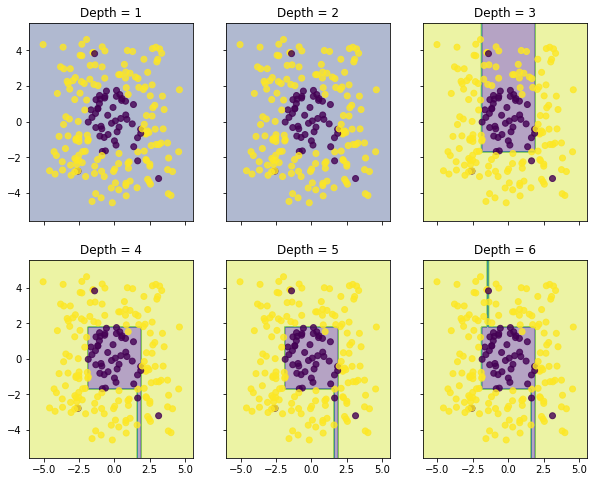

In [29]:
# Training classifiers with different depth
clf1 = Classification_Tree(max_depth=1, min_sample=2)
clf1.fit(x_train, y_train_label)

clf2 = Classification_Tree(max_depth=2, min_sample=2)
clf2.fit(x_train, y_train_label)

clf3 = Classification_Tree(max_depth=3, min_sample=2)
clf3.fit(x_train, y_train_label)

clf4 = Classification_Tree(max_depth=4, min_sample=2)
clf4.fit(x_train, y_train_label)

clf5 = Classification_Tree(max_depth=5, min_sample=2)
clf5.fit(x_train, y_train_label)

clf6 = Classification_Tree(max_depth=6, min_sample=2)
clf6.fit(x_train, y_train_label)

# Plotting decision regions
x_min, x_max = x_train[:, 0].min() - 1, x_train[:, 0].max() + 1
y_min, y_max = x_train[:, 1].min() - 1, x_train[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(2, 3, sharex='col', sharey='row', figsize=(10, 8))

for idx, clf, tt in zip(product([0, 1], [0, 1, 2]),
                        [clf1, clf2, clf3, clf4, clf5, clf6],
                        ['Depth = {}'.format(n) for n in range(1, 7)]):

    Z = np.array([clf.predict_instance(x) for x in np.c_[xx.ravel(), yy.ravel()]])
    Z = Z.reshape(xx.shape)

    axarr[idx[0], idx[1]].contourf(xx, yy, Z, alpha=0.4)
    axarr[idx[0], idx[1]].scatter(x_train[:, 0], x_train[:, 1], c=y_train_label[:,0], alpha=0.8)
    axarr[idx[0], idx[1]].set_title(tt)

plt.show()

# Compare decision tree with tree model in sklearn

In [30]:
clf = DecisionTreeClassifier(criterion='entropy', max_depth=3, min_samples_split=2)
clf.fit(x_train, y_train_label)
export_graphviz(clf, out_file='tree_classifier.dot')

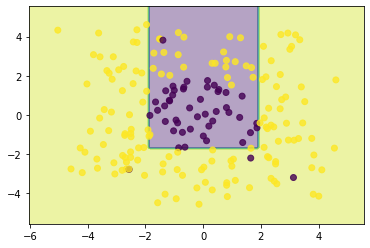

In [31]:
# Plotting decision regions
x_min, x_max = x_train[:, 0].min() - 1, x_train[:, 0].max() + 1
y_min, y_max = x_train[:, 1].min() - 1, x_train[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

Z = np.array([clf.predict(x[np.newaxis,:]) for x in np.c_[xx.ravel(), yy.ravel()]])
Z = Z.reshape(xx.shape)
plt.figure()
plt.contourf(xx, yy, Z, alpha=0.4)
plt.scatter(x_train[:, 0], x_train[:, 1], 
c=y_train_label[:,0], alpha=0.8)

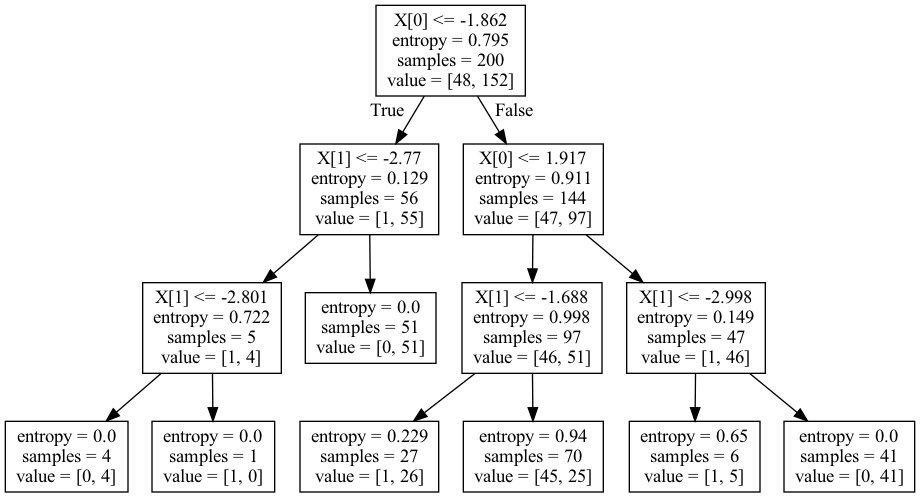

In [11]:
# Visualize decision tree
!dot -Tpng tree_classifier.dot -o tree_classifier.png
Image(filename='tree_classifier.png')

# Decision Tree Regressor

### Q4: Complete the function mean absolute deviation around median (MAE). Use the code provided to fit the Regression Tree to the krr dataset using both the MAE loss and me- dian predictions. Include the plots for the 6 fits.

In [12]:
# Regression Tree Specific Code
def mean_absolute_deviation_around_median(y):
    '''
    Calulate the mean absolute deviation around the median of a given target list
    :param y: a numpy array of targets shape = (n, 1)
    :return mae
    '''
    # Your code goes here
    # mean of abs(y - median(y))
    mae = np.mean(np.abs(y-np.median(y)))
    
    return mae

In [13]:
class Regression_Tree():
    '''
    :attribute loss_function_dict: dictionary containing the loss functions used for splitting
    :attribute estimator_dict: dictionary containing the estimation functions used in leaf nodes
    '''

    loss_function_dict = {
        'mse': np.var,
        'mae': mean_absolute_deviation_around_median
    }

    estimator_dict = {
        'mean': np.mean,
        'median': np.median
    }
    
    def __init__(self, loss_function='mse', estimator='mean', min_sample=5, max_depth=10):
        '''
        Initialize Regression_Tree
        :param loss_function(str): loss function used for splitting internal nodes
        :param estimator(str): value estimator of internal node
        '''

        self.tree = Decision_Tree(self.loss_function_dict[loss_function],
                                  self.estimator_dict[estimator],
                                  0, min_sample, max_depth)

    def fit(self, X, y=None):
        self.tree.fit(X,y)
        return self

    def predict_instance(self, instance):
        value = self.tree.predict_instance(instance)
        return value

# Fit regression tree to one-dimensional regression data

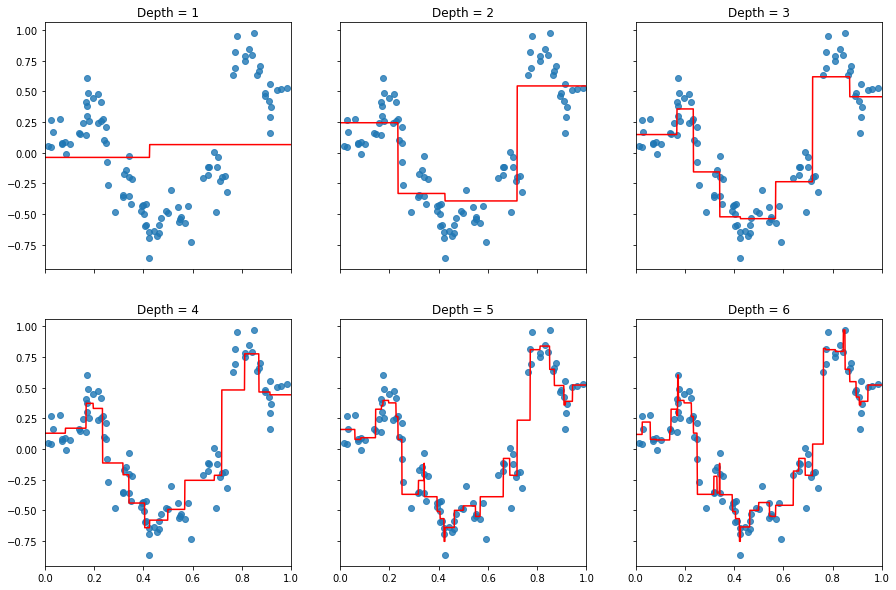

In [25]:
data_krr_train = np.loadtxt('krr-train.txt')
data_krr_test = np.loadtxt('krr-test.txt')
x_krr_train, y_krr_train = data_krr_train[:,0].reshape(-1,1),data_krr_train[:,1].reshape(-1,1)
x_krr_test, y_krr_test = data_krr_test[:,0].reshape(-1,1),data_krr_test[:,1].reshape(-1,1)

# Training regression trees with different depth
clf1 = Regression_Tree(max_depth=1,  min_sample=3, loss_function='mae', estimator='mean')
clf1.fit(x_krr_train, y_krr_train)

clf2 = Regression_Tree(max_depth=2,  min_sample=3, loss_function='mae', estimator='mean')
clf2.fit(x_krr_train, y_krr_train)

clf3 = Regression_Tree(max_depth=3,  min_sample=3, loss_function='mae', estimator='mean')
clf3.fit(x_krr_train, y_krr_train)

clf4 = Regression_Tree(max_depth=4,  min_sample=3, loss_function='mae', estimator='mean')
clf4.fit(x_krr_train, y_krr_train)

clf5 = Regression_Tree(max_depth=5,  min_sample=3, loss_function='mae', estimator='mean')
clf5.fit(x_krr_train, y_krr_train)

clf6 = Regression_Tree(max_depth=10,  min_sample=3, loss_function='mae', estimator='mean')
clf6.fit(x_krr_train, y_krr_train)

plot_size = 0.001
x_range = np.arange(0., 1., plot_size).reshape(-1, 1)

f2, axarr2 = plt.subplots(2, 3, sharex='col', sharey='row', figsize=(15, 10))

for idx, clf, tt in zip(product([0, 1], [0, 1, 2]),
                        [clf1, clf2, clf3, clf4, clf5, clf6],
                        ['Depth = {}'.format(n) for n in range(1, 7)]):

    y_range_predict = np.array([clf.predict_instance(x) for x in x_range]).reshape(-1, 1)
  
    axarr2[idx[0], idx[1]].plot(x_range, y_range_predict, color='r')
    axarr2[idx[0], idx[1]].scatter(x_krr_train, y_krr_train, alpha=0.8)
    axarr2[idx[0], idx[1]].set_title(tt)
    axarr2[idx[0], idx[1]].set_xlim(0, 1)
plt.show()

# Compare with scikit-learn for debugging

In [15]:
# DecisionTreeRegressor(criterion=, max_depth=, min_samples_split=)

# Gradient Boosting Method

### Q5: Complete the gradient boosting class. As the base regression algorithm to compute the argmin, you should use sklearn’s regression tree. You should use the square loss for the tree splitting rule (criterion keyword argument) and use the default sklearn leaf prediction rule from the predict method 1. We will also use a constant step size ν.

In [16]:
#Pseudo-residual function.

def pseudo_residual_L2(train_target, train_predict):
    '''
    Compute the pseudo-residual based on current predicted value. 
    '''
    return train_target - train_predict


In [17]:
class gradient_boosting():
    '''
    Gradient Boosting regressor class
    :method fit: fitting model
    '''
    def __init__(self, n_estimator, pseudo_residual_func, learning_rate=0.01, 
                 min_sample=5, max_depth=5):
        '''
        Initialize gradient boosting class
        
        :param n_estimator: number of estimators (i.e. number of rounds of gradient boosting)
        :pseudo_residual_func: function used for computing pseudo-residual between training labels and predicted labels at each iteration
        :param learning_rate: step size of gradient descent
        '''
        self.n_estimator = n_estimator
        self.pseudo_residual_func = pseudo_residual_func
        self.learning_rate = learning_rate
        self.min_sample = min_sample
        self.max_depth = max_depth

        self.estimators = [] #will collect the n_estimator models
    
    def fit(self, train_data, train_target):
        '''
        Fit gradient boosting model
        :train_data array of inputs of size (n_samples, m_features) 
        :train_target array of outputs of size (n_samples,) 
        '''
        # Your code goes here             
        for _ in range(self.n_estimator):
            residual = pseudo_residual_L2(train_target, self.predict(train_data))
            h_m = DecisionTreeRegressor(max_depth=self.max_depth, min_samples_split=self.min_sample)
            h_m.fit(train_data, residual)
         
            self.estimators.append(h_m) 
    
    def predict(self, test_data):
        '''
        Predict value
        :train_data array of inputs of size (n_samples, m_features)
        '''
        # Your code goes here
        test_predict = np.zeros(len(test_data))
        for h_m in self.estimators:
            test_predict += self.learning_rate * h_m.predict(test_data)        
        
        return test_predict

# 1-D GBM visualization - KRR data

### Q6: Run the code provided to build gradient boosting models on the regression data sets krr-train.txt, and include the plots generated. For debugging you can use the sklearn implementation of GradientBoostingRegressor2.

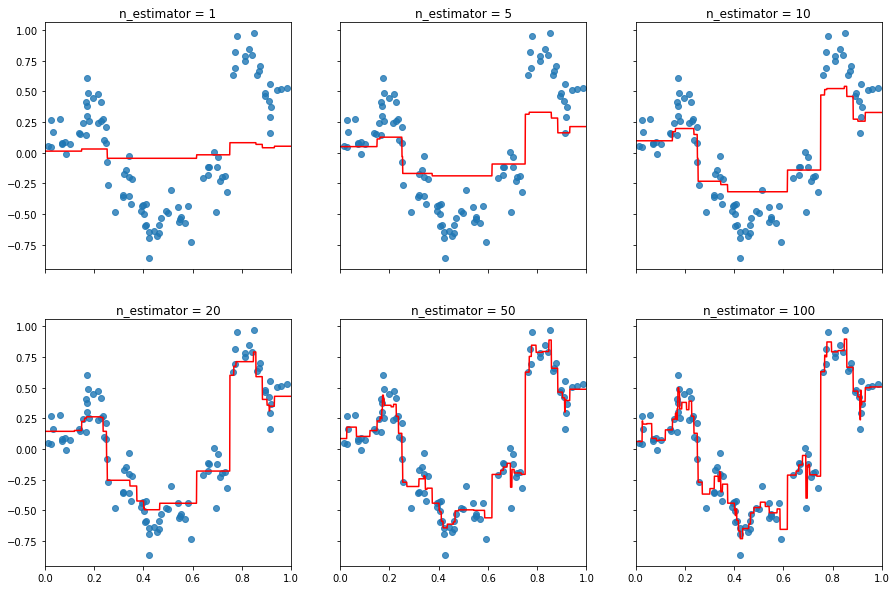

In [18]:
plot_size = 0.001
x_range = np.arange(0., 1., plot_size).reshape(-1, 1)

f2, axarr2 = plt.subplots(2, 3, sharex='col', sharey='row', figsize=(15, 10))

for idx, i, tt in zip(product([0, 1], [0, 1, 2]),
                       [1, 5, 10, 20, 50, 100], 
                       ['n_estimator = {}'.format(n) for n in [1, 5, 10, 20, 50, 100]]):
    
    gbm_1d = gradient_boosting(n_estimator=i, pseudo_residual_func=pseudo_residual_L2, 
                               max_depth=3, learning_rate=0.1)  
    gbm_1d.fit(x_krr_train, y_krr_train[:,0])
    
    y_range_predict = gbm_1d.predict(x_range)

    axarr2[idx[0], idx[1]].plot(x_range, y_range_predict, color='r')
    axarr2[idx[0], idx[1]].scatter(x_krr_train, y_krr_train, alpha=0.8)
    axarr2[idx[0], idx[1]].set_title(tt)
    axarr2[idx[0], idx[1]].set_xlim(0, 1)

# Sklearn implementation for Classification of images

### Q9: Load the MNIST dataset using the helper preprocessing function in the skeleton code.Using the scikit learn implementation of GradientBoostingClassifier, with the logistic loss (loss=‘deviance’) and trees of maximum depth 3, fit the data with 2, 5, 10, 100 and 200 iterations (estimators). Plot the train and test accurary as a function of the number of estimators.

In [19]:
from sklearn.datasets import fetch_openml
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import check_random_state

In [20]:
def pre_process_mnist_01():
    """
    Load the mnist datasets, selects the classes 0 and 1 
    and normalize the data.
    Args: none
    Outputs: 
        X_train: np.array of size (n_training_samples, n_features)
        X_test: np.array of size (n_test_samples, n_features)
        y_train: np.array of size (n_training_samples)
        y_test: np.array of size (n_test_samples)
    """
    X_mnist, y_mnist = fetch_openml('mnist_784', version=1, 
                                    return_X_y=True, as_frame=False)
    indicator_01 = (y_mnist == '0') + (y_mnist == '1') 
    X_mnist_01 = X_mnist[indicator_01]
    y_mnist_01 = y_mnist[indicator_01]
    X_train, X_test, y_train, y_test = train_test_split(X_mnist_01, y_mnist_01,
                                                        test_size=0.33,
                                                        shuffle=False)

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train) 
    X_test = scaler.transform(X_test)

    y_test = 2 * np.array([int(y) for y in y_test]) - 1
    y_train = 2 * np.array([int(y) for y in y_train]) - 1
    return X_train, X_test, y_train, y_test

In [21]:
X_train, X_test, y_train, y_test = pre_process_mnist_01()

n_estimator:2, train_acc:0.9954554635427186, test_acc:0.9952849528495284
n_estimator:5, train_acc:0.9972732781256312, test_acc:0.995489954899549
n_estimator:10, train_acc:0.9972732781256312, test_acc:0.9952849528495284
n_estimator:100, train_acc:1.0, test_acc:0.998359983599836
n_estimator:200, train_acc:1.0, test_acc:0.9985649856498565


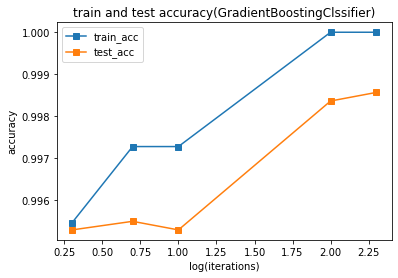

In [22]:
estimators_list = [2, 5, 10, 100, 200]
train_acc, test_acc = [], []


for estimator in estimators_list:
    gb_cf = GradientBoostingClassifier(loss = 'deviance', max_depth = 3, n_estimators=estimator)
    gb_cf.fit(X_train, y_train)
    
    train_acc.append(gb_cf.score(X_train, y_train))
    test_acc.append(gb_cf.score(X_test, y_test))

for i in range(len(estimators_list)):
    print('n_estimator:{}, train_acc:{}, test_acc:{}'.format(estimators_list[i], train_acc[i], test_acc[i]))
    
plt.plot(np.log10(estimators_list), train_acc, marker='s', label='train_acc')
plt.plot(np.log10(estimators_list), test_acc, marker='s', label='test_acc')
plt.title('train and test accuracy(GradientBoostingClssifier)')
plt.xlabel('log(iterations)')
plt.ylabel('accuracy')
plt.legend()
plt.show()

## Q10: 
- Another type of ensembling method we discussed in class are random forests. Explain in your own words the construction principle of random forests.

### Answer)
- First, given n train sets(X1, y1), ...(Xn, yn)), select B random samples with replacement(bootstrap method). Then create a (decision) tree from given B random samples. Build a collection of trees indepently and in parallel. 


- When building a single tree, restrict splitting rule from choosing all features(p) to choosing random subset of features(m). Select best split point and split node into child nodes. Iterate until tree is built by given conditions.(i.e. setting max depth, min split node). Also, typically choose m = p^(0.5). 


- After getting result from each trees, aggregate results by either majority vote or average of prediction. (Generally, use majority vote for classification and average for regression tasks)

## Q11

n_estimator:2, train_acc:0.9932336901636033, test_acc:0.992209922099221
n_estimator:5, train_acc:0.9960614017370228, test_acc:0.9977449774497745
n_estimator:10, train_acc:0.9968693193294283, test_acc:0.997539975399754
n_estimator:50, train_acc:0.9982831751161382, test_acc:0.998769987699877
n_estimator:100, train_acc:0.997677236921834, test_acc:0.998769987699877
n_estimator:200, train_acc:0.9979802060189861, test_acc:0.9989749897498975


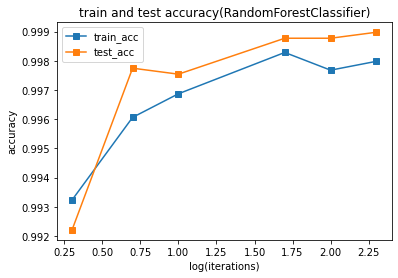

In [50]:
# create RandomForestClassifier and fit
# to answer Q12, plot both train and test acc
estimators_list = [2, 5, 10, 50, 100, 200]
train_acc, test_acc = [], []


for estimator in estimators_list:
    rf_cf = RandomForestClassifier(criterion = 'entropy', max_depth = 3, n_estimators=estimator)
    rf_cf.fit(X_train, y_train)
    
    train_acc.append(rf_cf.score(X_train, y_train))
    test_acc.append(rf_cf.score(X_test, y_test))

for i in range(len(estimators_list)):
    print('n_estimator:{}, train_acc:{}, test_acc:{}'.format(estimators_list[i], train_acc[i], test_acc[i]))
    
plt.plot(np.log10(estimators_list), train_acc, marker='s', label='train_acc')
plt.plot(np.log10(estimators_list), test_acc, marker='s', label='test_acc')
plt.title('train and test accuracy(RandomForestClassifier)')
plt.xlabel('log(iterations)')
plt.ylabel('accuracy')
plt.legend()
plt.show()

## Q12
- What general remark can you make on overfitting for Random Forests and Gradient Boosted Trees? Which method achieves the best train accuracy overall? Is this result expected? Can you think of a practical disadvantage of the best performing method? How do the algorithms compare in term of test accuracy?

### Answer)
- What general remark can you make on overfitting for Random Forests and Gradient Boosted Trees?
>Both models are not overfitted. For Random Forests, we can see that test accuracy is higher than train accuracy, and test accuracy tends to increase even n_estimator gets larger.  
Random Forests)  
n_estimator:100, train_acc:0.997677236921834, test_acc:0.998769987699877 ->
n_estimator:200, train_acc:0.9979802060189861, test_acc:0.9989749897498975
For Gradient Boosted Trees, we can also see that test accuracy tends to get better even train accuracy gets 1.0 already.  
Gradient Boosted Trees)  
n_estimator:100, train_acc:1.0, test_acc:0.998359983599836 -> 
n_estimator:200, train_acc:1.0, test_acc:0.9985649856498565


- Which method achieves the best train accuracy overall? Is this result expected? 
>Gradient Boosted Trees achieves the best train accuracy for every n_estimators. This result is expected as boosting models iteratively trains from weak-learners. By giving penalties for previous model's errors, boosting tree models focuses on errors, and therefore generally outperforms random forest models.


- Can you think of a practical disadvantage of the best performing method? 
>As Gradient Boosted Trees is training sequently, computation time is larger than other models. Even recent SOTA models(XGBoost, LightGBM) are better optimized in terms of computation time, but still slower than other models.  
Also, as the model continues to reduce all errors, it might focus too much on outliers, and may lead to overfitting. We should be aware of overfitting risk and set regularization parameters when training data.
- How do the algorithms compare in term of test accuracy?
> Random Forests showed better test accuracy. (For n_estimators: 5, 10, 100, 200). However, we can assume that Gradient Boosted Trees will perform better as n_estimators gets larger. (test accuracy gap betwwen Random Forests and Gradient Boosted Trees are getting smaller)